In [1]:
# !pip install wordcloud


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models.word2vec import Word2Vec
import re
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [3]:
# Load Data

import pandas as pd
import os

data_dir = os.getcwd()
df = pd.read_csv(os.path.join(data_dir, "spam.csv"), encoding='utf8')

df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# 불용어 처리

nltk.download('stopwords')

stop_words = set(stopwords.words("english"))

def preprocess(text):
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

df['v2'] = df['v2'].apply(preprocess)
df['v2']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sbcho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry wkly comp win fa cup final tkts st ...
3                     u dun say early hor u c already say
4                  nah think goes usf lives around though
                              ...                        
5567    nd time tried contact u u pound prize claim ea...
5568                            b going esplanade fr home
5569                                pity mood suggestions
5570    guy bitching acted like interested buying some...
5571                                       rofl true name
Name: v2, Length: 5572, dtype: object

In [5]:
# 소문자로 변환 및 토큰화
df['tokenize'] = df['v2'].map(lambda text: word_tokenize(text.lower()))
df

,v1,v2,tokenize
0,ham,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,free entry wkly comp win fa cup final tkts st ...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,u dun say early hor u c already say,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,nah think goes usf lives around though,"[nah, think, goes, usf, lives, around, though]"
...,...,...,...
5567,spam,nd time tried contact u u pound prize claim ea...,"[nd, time, tried, contact, u, u, pound, prize,..."
5568,ham,b going esplanade fr home,"[b, going, esplanade, fr, home]"
5569,ham,pity mood suggestions,"[pity, mood, suggestions]"
5570,ham,guy bitching acted like interested buying some...,"[guy, bitching, acted, like, interested, buyin..."


In [6]:
df['v1'] = df['v1'].map({'spam': 1, 'ham': 0})
df

,v1,v2,tokenize
0,0,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n..."
1,0,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,free entry wkly comp win fa cup final tkts st ...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,u dun say early hor u c already say,"[u, dun, say, early, hor, u, c, already, say]"
4,0,nah think goes usf lives around though,"[nah, think, goes, usf, lives, around, though]"
...,...,...,...
5567,1,nd time tried contact u u pound prize claim ea...,"[nd, time, tried, contact, u, u, pound, prize,..."
5568,0,b going esplanade fr home,"[b, going, esplanade, fr, home]"
5569,0,pity mood suggestions,"[pity, mood, suggestions]"
5570,0,guy bitching acted like interested buying some...,"[guy, bitching, acted, like, interested, buyin..."


In [7]:
cv = CountVectorizer()

# 스팸 메일의 텍스트 데이터 추출
spam_texts = df[df['v1'] == 1]['v2']

# 단어의 빈도 계산
word_count = cv.fit_transform(spam_texts)

# 단어와 그 빈도 DataFrame화
word_count_df = pd.DataFrame({'word': cv.get_feature_names_out(), 'count': word_count.sum(axis=0).A1})

# 단어의 빈도 상위 10개 단어 출력
top_10_words = word_count_df.sort_values('count', ascending=False).head(10)
top_10_words


,word,count
208,call,370
599,free,228
1750,txt,170
1789,ur,144
1008,mobile,129
1574,stop,126
1659,text,126
280,claim,113
1359,reply,104
1923,www,98


In [8]:
# CBOW(Continuous Bag of Words) 방식을 사용하는 Word2Vec 모델 생성
cbow = Word2Vec(df['tokenize'], vector_size=64, window=5, sg=0)

# 'call' 단어의 벡터 출력
cbow.wv['call']

array([ 0.81487626, -0.63808113,  0.405601  ,  0.4935551 ,  0.271219  ,
       -0.67714936,  0.22046763, -0.5360936 , -0.8503321 , -0.30941316,
        0.72356737, -0.6829307 , -0.45461634, -0.6681077 , -0.05164753,
        0.8826532 , -0.2952601 , -0.2601432 , -0.07171458,  1.2321748 ,
        0.47726324,  0.9226763 ,  0.32330397, -1.0128895 , -0.42994586,
        0.44524086, -0.68340904,  0.0138802 ,  0.28622445, -0.38224846,
        0.53908217,  0.3176119 , -0.01080184, -0.4966808 , -0.29318652,
       -0.11885577,  0.1447383 , -0.16569445, -0.11838197,  0.18757258,
       -0.12106449,  0.17990296, -0.24767753, -0.00941495,  0.8805324 ,
       -0.45167604,  0.10005032, -0.4540831 ,  0.07183228,  0.47234276,
        0.01661664,  0.10033651,  0.48788902,  0.4501079 ,  0.14301439,
       -0.00596562,  0.18887648, -0.6157176 , -0.6458182 ,  0.2652476 ,
       -0.64713097, -0.37447554,  0.113721  , -0.02726944], dtype=float32)

In [9]:
# 'call' 단어와 가장 유사한 단어 10개 출력
similar_words = cbow.wv.most_similar(positive=["call"], topn=10)
print(similar_words)

[('mobile', 0.9993497133255005), ('msg', 0.9991841912269592), ('c', 0.9991804361343384), ('number', 0.9991666674613953), ('reply', 0.9991521239280701), ('service', 0.9991094470024109), ('please', 0.9991002082824707), ('receive', 0.9990295171737671), ('cash', 0.9990267753601074), ('txt', 0.9990224838256836)]


In [10]:
# Skip-gram 방식을 사용하는 Word2Vec 모델 생성
skipGram = Word2Vec(df['tokenize'], vector_size=64, window=5, sg=1)

# 'call' 단어의 벡터 출력
skipGram.wv['call']

array([ 0.22047941, -0.11440857,  0.07042319,  0.2063082 ,  0.18288991,
       -0.33774313,  0.23955551, -0.1111628 , -0.27659714, -0.12423959,
        0.57931834, -0.18217957, -0.15444161, -0.25458091, -0.12010723,
        0.14248078, -0.00753077, -0.42071033,  0.02365472,  0.6457822 ,
       -0.16438209,  0.5002375 ,  0.11274146, -0.37995836, -0.318365  ,
        0.12148456,  0.05157847,  0.0774285 ,  0.18781379,  0.01696312,
        0.2877083 ,  0.02992854, -0.16822322,  0.2200303 , -0.12556522,
       -0.18220557, -0.4709555 , -0.0067946 , -0.2951599 , -0.15216954,
       -0.352916  ,  0.17139937, -0.18563473,  0.39539143,  0.5164689 ,
        0.03328818, -0.0619639 , -0.17366882,  0.04054979,  0.60101354,
       -0.11540727,  0.18137181,  0.46251127,  0.19603053, -0.12921192,
        0.0862347 ,  0.25189367, -0.37752652, -0.04525071, -0.07290089,
       -0.43419182, -0.2318705 ,  0.07727857, -0.25865352], dtype=float32)

In [11]:
# 'call' 단어와 가장 유사한 단어 10개 출력
similar_words = skipGram.wv.most_similar(positive=["call"], topn=10)
print(similar_words)

[('line', 0.9751347303390503), ('land', 0.9717778563499451), ('code', 0.9717262387275696), ('landline', 0.9698634743690491), ('awarded', 0.969680666923523), ('guaranteed', 0.9686046838760376), ('award', 0.9676254987716675), ('valid', 0.9673910737037659), ('urgent', 0.9672806859016418), ('bonus', 0.9670394062995911)]


In [12]:
df

,v1,v2,tokenize
0,0,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n..."
1,0,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,1,free entry wkly comp win fa cup final tkts st ...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,0,u dun say early hor u c already say,"[u, dun, say, early, hor, u, c, already, say]"
4,0,nah think goes usf lives around though,"[nah, think, goes, usf, lives, around, though]"
...,...,...,...
5567,1,nd time tried contact u u pound prize claim ea...,"[nd, time, tried, contact, u, u, pound, prize,..."
5568,0,b going esplanade fr home,"[b, going, esplanade, fr, home]"
5569,0,pity mood suggestions,"[pity, mood, suggestions]"
5570,0,guy bitching acted like interested buying some...,"[guy, bitching, acted, like, interested, buyin..."


In [13]:
# CountVectorizer 객체 생성 (단어 빈도수에 기반한 벡터로 변환)
vectorizer = CountVectorizer()

# 텍스트 데이터를 벡터로 변환
X = vectorizer.fit_transform(df['v2'])

X_train, X_test, y_train, y_test = train_test_split(X, df['v1'], test_size=0.2, random_state=42)


In [14]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [15]:
preds = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, preds))
print(confusion_matrix(y_test, preds))

Accuracy:  0.9766816143497757
[[965   0]
 [ 26 124]]


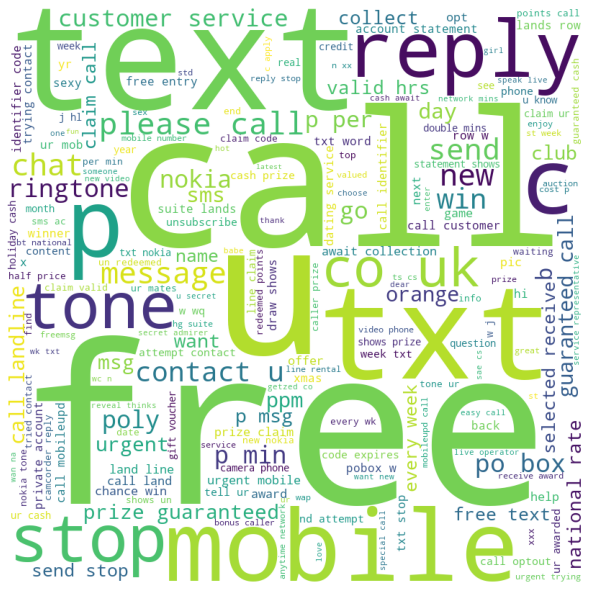

In [16]:
# 스팸 메일 텍스트 추출
spam_texts = ' '.join(df[df['v1'] == 1]['v2'])

# WordCloud 생성
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(spam_texts)

# WordCloud 시각화
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


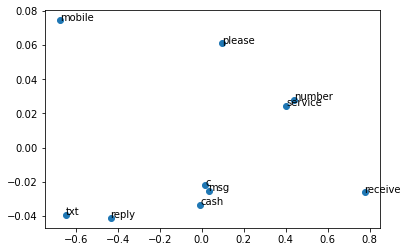

In [17]:
# 'call'과 유사한 단어 추출
similar_words = cbow.wv.most_similar(positive=["call"], topn=10)

# 유사한 단어와 그들의 벡터를 가져옴
words = [word[0] for word in similar_words]
vectors = [cbow.wv[word] for word in words]

# PCA를 이용하여 2차원으로 축소
pca = PCA(n_components=2)
result = pca.fit_transform(vectors)

# 단어를 2차원 공간에 표시
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()


D:\ProgramFiles\Anaconda3-2020.02-Windows-x86_64.exe\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


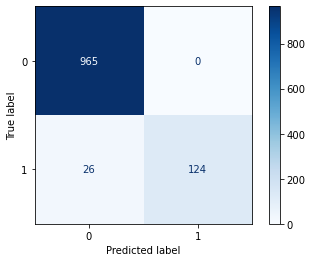

In [18]:
# confusion matrix 시각화
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
plt.show()
